In [1]:
import numpy as np
import random
n=2
k=2
M=2**k
#Generate random numbers between 0 and 15 for training data
symbols = np.random.randint(0,M,100000)
X_train = np.zeros((symbols.size, symbols.max()+1))
X_train[np.arange(symbols.size),symbols] = 1
#X_train.shape

In [2]:
#Generate random numbers between 0 and 15 for test data
symbols = np.random.randint(0,M,10000)
X_test = np.zeros((symbols.size, symbols.max()+1))
X_test[np.arange(symbols.size),symbols] = 1

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model 
from keras.layers import Input, Dense, ReLU, BatchNormalization 
inputs= X_test.shape[1]

In [4]:
from keras import layers
from keras import backend
from keras.engine import base_layer
from keras.utils import tf_utils
import tensorflow as tf
from tensorflow.python.util.tf_export import keras_export
@keras_export('keras.layers.Fsolayer')
class Fsolayer(base_layer.BaseRandomLayer):

  def __init__(self, **kwargs):
    super(Fsolayer, self).__init__( **kwargs)
    self.supports_masking = True

  def call(self, inputs, training=None):

    def noised():
      J_S_D=0.3     #%%% Jetter Standard Deviation
      H_l=0.8      #%%%% pass loss factor
      a=0.1        #%%% Radius
      R=0.5         #%%% responsitivity
      L=2000        #%%%% distance in m
      theta=2.5/1000 #%%% divergence angle
      W_z=theta*L     #%%% Beam radius
      wl=1550/1000000000   #%%%% wavelength in nm	
      ha = []
      alpha = 4.505303125003634
      beta  = 2.714091563350723
      elements = 1	
      temp1 = random.gammavariate(alpha, 1/alpha)
      temp2 = random.gammavariate(beta, 1/beta)
      ha = temp1*temp2
      W_z_eq = 5.001047351093471
      A_o = 6.774000000000000e-04
      r_pdf = np.random.rayleigh(J_S_D,elements)
      r_pdf = list(r_pdf)
      hp = A_o*np.exp(-np.multiply(r_pdf,r_pdf)*2/W_z_eq)
      return inputs*ha

    return backend.in_train_phase(noised, inputs, training=training)

  def get_config(self):
    config = {}
    base_config = super(Fsolayer, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

  @tf_utils.shape_type_conversion
  def compute_output_shape(self, input_shape):
    return input_shape

In [5]:
class CustomLayer(keras.layers.Layer):
    def __init__(self, units=32, **kwargs):
        super(CustomLayer, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

    def get_config(self):
        config = super(CustomLayer, self).get_config()
        config.update({"units": self.units})
        return config


def custom_activation(x,axis=-1):
    return tf.abs(x)/tf.sqrt(tf.reduce_sum(x*x, axis=axis, keepdims=True)/x.shape[1])

In [6]:
#define the encoder 
encoder_input= Input(shape=(inputs,))
encoder_layer=Dense(inputs, activation="relu")(encoder_input)
encoder_layer=Dense(n, activation="linear")(encoder_layer)
encoder_output= BatchNormalization()(encoder_layer) 
# encoder_output= keras.layers.Activation(custom_activation)(encoder_layer) 

In [7]:
R=4/7;
Eb_No_training=7; ## dB -215dm variance
Eb_No_training_ratio=10**(Eb_No_training/10);
stddev=(2*R*Eb_No_training_ratio)**(-0.5);
N_S_D=1e-07; 
fso=Fsolayer()(encoder_output)
channel_output=tf.keras.layers.GaussianNoise(N_S_D)(fso) 

In [8]:
# define the decoder 
decoder= Dense(inputs, activation="relu")(channel_output) 
decoder_output = Dense(inputs, activation="softmax")(decoder)

In [9]:
# define the autoencoder

autoencoder=Model(inputs=encoder_input, outputs=decoder_output)

## encoder side
encoder=Model(inputs=encoder_input, outputs=encoder_output)

#decoder side 
decoder=Model(inputs=channel_output, outputs=decoder_output)

In [10]:
autoencoder.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
history=autoencoder.fit(X_train,X_train,epochs=30, validation_data=(X_test,X_test),batch_size=1000)
#autoencoder.save("functional_encoder.h5")

Epoch 1/30
100/100 [==============================] - 2s 4ms/step - loss: 1.3170 - accuracy: 0.6183 - val_loss: 1.1999 - val_accuracy: 0.4972
Epoch 2/30
100/100 [==============================] - 0s 2ms/step - loss: 1.1199 - accuracy: 0.7516 - val_loss: 0.8670 - val_accuracy: 0.7583
Epoch 3/30
100/100 [==============================] - 0s 2ms/step - loss: 0.9096 - accuracy: 0.8641 - val_loss: 0.5841 - val_accuracy: 1.0000
Epoch 4/30
100/100 [==============================] - 0s 2ms/step - loss: 0.7109 - accuracy: 1.0000 - val_loss: 0.3915 - val_accuracy: 1.0000
Epoch 5/30
100/100 [==============================] - 0s 2ms/step - loss: 0.5235 - accuracy: 1.0000 - val_loss: 0.1650 - val_accuracy: 1.0000
Epoch 6/30
100/100 [==============================] - 0s 2ms/step - loss: 0.3195 - accuracy: 1.0000 - val_loss: 0.0398 - val_accuracy: 1.0000
Epoch 7/30
100/100 [==============================] - 0s 3ms/step - loss: 0.1871 - accuracy: 1.0000 - val_loss: 0.0116 - val_accuracy: 1.0000
Epoch 

In [11]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 2)                 10        
                                                                 
 batch_normalization (BatchN  (None, 2)                8         
 ormalization)                                                   
                                                                 
 fsolayer (Fsolayer)         (None, 2)                 0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 2)                0         
 se)                                                         

In [12]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 4)                 20        
                                                                 
 dense_1 (Dense)             (None, 2)                 10        
                                                                 
 batch_normalization (BatchN  (None, 2)                8         
 ormalization)                                                   
                                                                 
Total params: 38
Trainable params: 34
Non-trainable params: 4
_________________________________________________________________


In [13]:
decoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 12        
                                                                 
 dense_3 (Dense)             (None, 4)                 20        
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


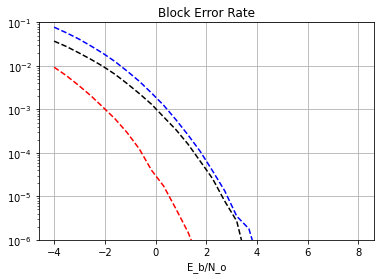

In [18]:
d2 = np.load('BER_2_2.npz')
d4 = np.load('BER_4_2.npz')
d7 = np.load('BER_7_4.npz')
import matplotlib.pyplot as plt
plt.semilogy(d2['Eb_No'], d2['BER'], 'k--',d4['Eb_No'], d4['BER'], 'r--',d7['Eb_No'], d7['BER'], 'b--')
plt.ylim(0.000001,0.1)
plt.title('Block Error Rate')
plt.xlabel('E_b/N_o')
plt.grid(True)
plt.show()
# print(d['BER'])
# print(d['Eb_No'])

In [19]:
#Generate random numbers between 0 and 15 for BER calculations
test_size=10000;
symbols = np.random.randint(0,M,test_size)
X_test = np.zeros((symbols.size, symbols.max()+1))
X_test[np.arange(symbols.size),symbols] = 1

#generating a E/N vector
R=4/7;
num_steps=26
Eb_No=np.linspace(-4,8,num_steps); ## dB
BER=np.zeros(num_steps)
for i in range(len(Eb_No)):
    if Eb_No[i]<=0:
        BE=np.zeros(1)
        for jj in range(100):
            H_l=0.8      #%%%% pass loss factor
            a=0.1        #%%% Radius
            R=0.5         #%%% responsitivity
            L=2000        #%%%% distance in m
            theta=2.5/1000 #%%% divergence angle
            W_z=theta*L     #%%% Beam radius
            wl=1550/1000000000   #%%%% wavelength in nm	
            ha = []
            alpha = 4.505303125003634
            beta  = 2.714091563350723
            elements = 1	
            temp1 = random.gammavariate(alpha, 1/alpha)
            temp2 = random.gammavariate(beta, 1/beta)
            ha = temp1*temp2
            Eb_No_ratio=10**(Eb_No[i]/10);
            stddev=(2*R*Eb_No_ratio)**(-0.5);
            encodedsymbols=encoder.predict(X_test)
            noise = np.random.normal(0,stddev,[test_size,n])
            noisy=ha*encodedsymbols+noise
            a=decoder.predict(noisy)
            idx = np.argmax(a, axis=-1)
            a = np.zeros( a.shape )
            a[ np.arange(a.shape[0]), idx] = 1
            recovered_symbols=np.argmax(a, axis=1)
            errors=np.count_nonzero(recovered_symbols-symbols)
            Erorrrrs=errors/len(symbols)
            BE+=Erorrrrs
        BER[i]=BE/100
    else:
        BE=np.zeros(1)
        for jj in range(500):
            H_l=0.8      #%%%% pass loss factor
            a=0.1        #%%% Radius
            R=0.5         #%%% responsitivity
            L=2000        #%%%% distance in m
            theta=2.5/1000 #%%% divergence angle
            W_z=theta*L     #%%% Beam radius
            wl=1550/1000000000   #%%%% wavelength in nm	
            ha = []
            alpha = 4.505303125003634
            beta  = 2.714091563350723
            elements = 1	
            temp1 = random.gammavariate(alpha, 1/alpha)
            temp2 = random.gammavariate(beta, 1/beta)
            ha = temp1*temp2
            Eb_No_ratio=10**(Eb_No[i]/10);
            stddev=(2*R*Eb_No_ratio)**(-0.5);
            encodedsymbols=encoder.predict(X_test)
            noise = np.random.normal(0,stddev,[test_size,n])
            noisy=ha*encodedsymbols+noise
            a=decoder.predict(noisy)
            idx = np.argmax(a, axis=-1)
            a = np.zeros( a.shape )
            a[ np.arange(a.shape[0]), idx] = 1
            recovered_symbols=np.argmax(a, axis=1)
            errors=np.count_nonzero(recovered_symbols-symbols)
            Erorrrrs=errors/len(symbols)
            BE+=Erorrrrs
        BER[i]=BE/500


313/313 [==============================] - 0s 746us/step


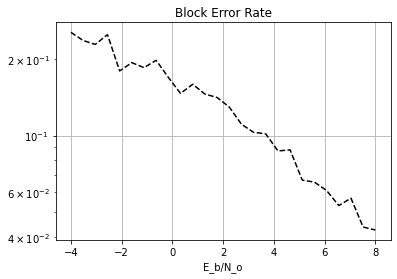

In [20]:
import matplotlib.pyplot as plt
plt.semilogy(Eb_No, BER, 'k--')
plt.title('Block Error Rate')
plt.xlabel('E_b/N_o')
plt.grid(True)
plt.show()

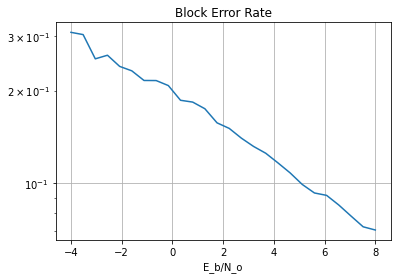

[0.234215  0.269917  0.192724  0.168667  0.178796  0.177363  0.159635
 0.174105  0.15559   0.1365094 0.1491946 0.1272688 0.106218  0.106993
 0.0887398 0.0920654 0.0949734 0.071759  0.0697956 0.0634918 0.0591556
 0.0513608 0.0485278 0.0443994 0.0409134 0.0349902]


In [5]:
d0 = np.load('BER_2_2_t.npz')
d1 = np.load('BER_2_2_t1.npz')
d2 = np.load('BER_2_2_t2.npz')
d3 = np.load('BER_2_2_t3.npz')
d4 = np.load('BER_2_2_t4.npz')
d5 = np.load('BER_2_2_t5.npz')
d_av=(d0['BER']+d1['BER']+d2['BER']+d3['BER']+d4['BER']+d5['BER'])/6
import matplotlib.pyplot as plt
plt.semilogy(d2['Eb_No'], d_av)
plt.title('Block Error Rate')
plt.xlabel('E_b/N_o')
plt.grid(True)
plt.show()
print(d0['BER'])
# print(d['Eb_No'])

In [21]:
np.savez('BER_2_2_t5.npz', BER=BER,Eb_No=Eb_No)

313/313 [==============================] - 0s 783us/step


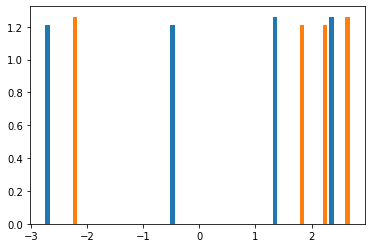

In [17]:
encodedsymbols=encoder.predict(X_test)
noise = np.random.normal(0,stddev/20,[len(X_test),n])
noisy=encodedsymbols+noise
import matplotlib.pyplot as plt
plt.hist(encodedsymbols, bins='auto', density=True)
plt.show()

c:\Users\moata\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\moata\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 87.73124265670776 seconds


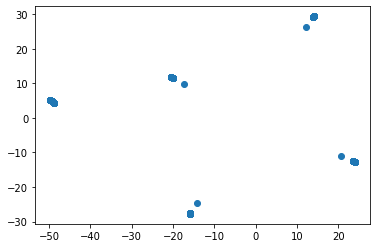

In [18]:
import time
from sklearn.manifold import TSNE

#n_sne = 7000

time_start = time.time()
tsne = TSNE( random_state=0)
tsne_results = tsne.fit_transform(encodedsymbols)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

plt.scatter(tsne_results[:,0],tsne_results[:,1])

c:\Users\moata\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\moata\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 80.26976680755615 seconds


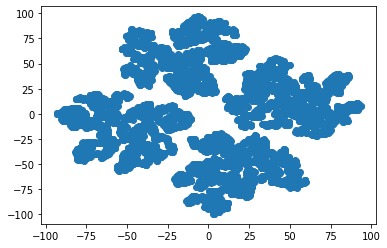

In [19]:
import time
from sklearn.manifold import TSNE

#n_sne = 7000

time_start = time.time()
tsne = TSNE( random_state=0)
tsne_results = tsne.fit_transform(noisy)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

plt.scatter(tsne_results[:,0],tsne_results[:,1])

In [20]:
decoded_symbols=decoder.predict(noisy)

313/313 [==============================] - 0s 747us/step


In [21]:
#convert the probability to hot vector
a=decoded_symbols
idx = np.argmax(a, axis=-1)
a = np.zeros( a.shape )
a[ np.arange(a.shape[0]), idx] = 1

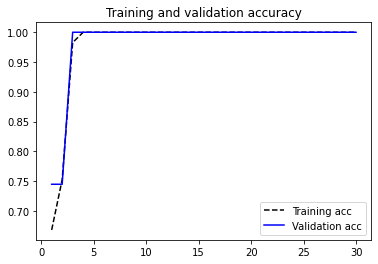

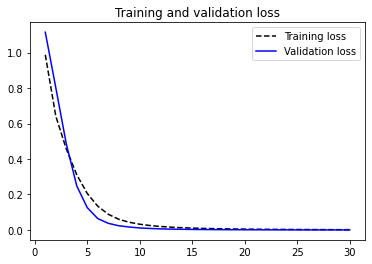

In [22]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'k--', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'k--', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
# #Generate random numbers between 0 and 15 for BER calculations
# test_size=1000000;
# symbols = np.random.randint(0,M,test_size)
# X_test = np.zeros((symbols.size, symbols.max()+1))
# X_test[np.arange(symbols.size),symbols] = 1

# #generating a E/N vector
# R=4/7;
# num_steps=26
# Eb_No=np.linspace(-4,8,num_steps); ## dB

In [24]:
# from tensorflow import keras
# from keras import layers
# class AE(layers.Layer):
#     def __init__(self):
#             super(AE, self).__init__()
#             self.fc1 = layers.Dense(16,activation='relu',input_dim=16)
#             self.fc2 = layers.Dense(7,activation='linear')
#             self.fc3 = layers.BatchNormalization()
#             self.fc4 = layers.GaussianNoise(stddev,name='noise')
#             self.fc5 = layers.Dense(16,activation='relu')
#             self.fc6 = layers.Dense(16,activation='softmax')



In [25]:
# # BER calculations without loops
# BER=np.zeros(num_steps)
# for i in range(len(Eb_No)):
#   Eb_No_ratio=10**(Eb_No[i]/10);
#   stddev=(2*R*Eb_No_ratio)**(-0.5);
#   encodedsymbols=encoder.predict(X_test)
#   noise = np.random.normal(0,stddev,[test_size,n])
#   noisy=encodedsymbols+noise
#   a=decoder.predict(noisy)
#   idx = np.argmax(a, axis=-1)
#   a = np.zeros( a.shape )
#   a[ np.arange(a.shape[0]), idx] = 1
#   recovered_symbols=np.argmax(a, axis=1)
#   errors=np.count_nonzero(recovered_symbols-symbols)
#   BER[i]=errors/len(symbols)


In [6]:
import GPUtil 
GPUtil. getAvailable()
import torch 
use_cuda = torch. cuda. is_available()
